# Task 4

In [53]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse 

G = pd.read_pickle('bigger_graph.pickle')
G

Number of nodes: 2767
Number of edges: 229384
Average degree: 165.79978315865557
Is the graph connected? True
Number of connected components: 1


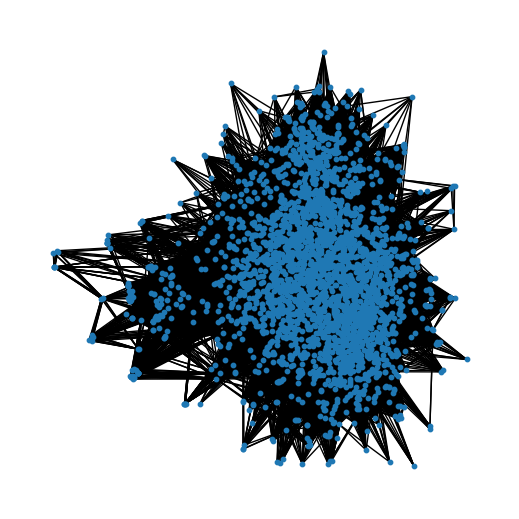

In [54]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
degrees = [G.degree(n) for n in G.nodes()]
print(f"Average degree: {sum(degrees) / len(degrees)}")
print(f"Is the graph connected? {nx.is_connected(G)}")
print(f"Number of connected components: {nx.number_connected_components(G)}")

plt.figure(figsize=(5, 5)) 
pos = nx.spring_layout(G)
nx.draw(G, pos , with_labels=False, node_size=10)
plt.show()

In [59]:
def count_links(G, node):
    return len(G.edges(node))

# Test the function
node = 'spotify:track:4g5QKYTjNoAN8w5LmNbkwo'
print(f"Node {node} has {count_links(G, node)} links.")


Node spotify:track:4g5QKYTjNoAN8w5LmNbkwo has 9 links.


In [55]:
def recommend_songs_weighted(graph, input_song, num_recommendations=5):
    recommended_songs = []

    if input_song in graph.nodes:
        current_song = input_song
        visited = set([current_song])
        
        while len(recommended_songs) < num_recommendations:
            neighbors = list(graph[current_song])
            neighbor_weights = [(neighbor, graph.edges[current_song, neighbor]['weight']) for neighbor in neighbors if neighbor not in visited]
            
            if not neighbor_weights:
                break
            
            # Sort neighbors by edge weights in descending order
            neighbor_weights.sort(key=lambda x: x[1], reverse=True)
            
            next_song = neighbor_weights[0][0]
            recommended_songs.append((next_song, neighbor_weights[0][1]))
            visited.add(next_song)
            current_song = next_song
        
        return recommended_songs
    else:
        print("Input song not found in the graph.")
        return None


input_song = "spotify:track:4g5QKYTjNoAN8w5LmNbkwo"  
num_recommendations = 5 
recommended_songs_weighted = recommend_songs_weighted(G, input_song, num_recommendations)
print("Recommended songs:")
for song in recommended_songs_weighted:
    print(song)

Recommended songs:
('spotify:track:0bXpmJyHHYPk6QBFj25bYF', 1)
('spotify:track:3n69hLUdIsSa1WlRmjMZlW', 2)
('spotify:track:0j6YwWZVHsIFKr5FDEu68o', 3)
('spotify:track:3UfCFlGruX0DRPCpD1V3pU', 3)
('spotify:track:1ivHxaGL5ld9VS1zsYc4YN', 3)


In [5]:
SPOTIPY_CLIENT_ID = '2c79005a25ff450fa2c58921fbfe370f'
SPOTIPY_CLIENT_SECRET = 'e6576447735343e28e391f30a16a9204'
#SPOTIPY_REDIRECT_URI = 'http://localhost:3000'

In [56]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Set up Spotify API credentials
SPOTIPY_CLIENT_ID = '2c79005a25ff450fa2c58921fbfe370f'
SPOTIPY_CLIENT_SECRET = 'e6576447735343e28e391f30a16a9204'

# Authenticate with Spotify API
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to get song features
def get_song_features(track_id):
    features = sp.audio_features([track_id])[0]
    return features

# Function to get artist features
def get_artist_features(artist_id):
    artist = sp.artist(artist_id)
    return artist['genres']

# Function to get track information
def get_track_info(track_id):
    track = sp.track(track_id)
    return track

# Assuming you have a consistent set of features for all songs
def vectorise_song_attributes(song_id):
    # Check if the song vector is already computed and stored
    if song_id in song_vectors:
        return song_vectors[song_id]
    
    # Retrieve track information
    track_info = get_track_info(song_id)
    
    # Retrieve artist ID
    artist_id = track_info['artists'][0]['id']
    
    # Retrieve song features
    features = get_song_features(song_id)
    
    # Retrieve artist features to get genre information
    artist_genres = get_artist_features(artist_id)
    
    # Flatten the artist_genres list to ensure it's 1D
    artist_genres_flat = [genre for sublist in artist_genres for genre in sublist]
    
    # Vectorise attributes
    genre = LabelEncoder().fit_transform(artist_genres_flat)
    artist = LabelEncoder().fit_transform([track_info['artists'][0]['name']])
    tempo = MinMaxScaler().fit_transform([[features['tempo']]])
    valence = MinMaxScaler().fit_transform([[features['valence']]])
    
    # Ensure all arrays are 1-dimensional for concatenation
    genre = genre.flatten()
    artist = artist.flatten()
    
    # Combine attributes into a single vector
    vector = np.concatenate((genre, artist, tempo.flatten(), valence.flatten()))
    
    # Ensure the vector has a consistent length
    target_length = 44  # Adjust this value based on your feature set
    if len(vector) < target_length:
        vector = np.pad(vector, (0, target_length - len(vector)), mode='constant')
    elif len(vector) > target_length:
        vector = vector[:target_length]
    
    # Store the computed vector
    song_vectors[song_id] = vector
    
    return vector

# Dictionary to store computed song vectors
song_vectors = {}

# Function to recommend songs based on cosine similarity
def recommend_songs(seed_song_id, num_recommendations=5):
    # Vectorise the seed song
    seed_vector = vectorise_song_attributes(seed_song_id)
    
    # Get the neighbors of the seed song
    neighbors = list(G.neighbors(seed_song_id))
    
    # Initialize a list to store neighbor vectors
    neighbor_vectors = []
    
    # Vectorise each neighbor song and store its vector
    for neighbor in neighbors:
        neighbor_vector = vectorise_song_attributes(neighbor)
        neighbor_vectors.append(neighbor_vector)
    
    # Convert the list of neighbor vectors into a 2D array
    neighbor_vectors_array = np.array(neighbor_vectors)
    
    # Calculate cosine similarity between the seed song vector and all neighbor vectors
    # Reshape the seed vector to match the shape expected by cosine_similarity
    similarities = cosine_similarity(seed_vector.reshape(1, -1), neighbor_vectors_array)
    
    # Flatten the similarities array and get the indices of the top N most similar neighbors
    top_indices = np.argsort(similarities.flatten())[-num_recommendations:][::-1]
    
    # Retrieve the song IDs of the top N most similar neighbors
    recommended_song_ids = [neighbors[i] for i in top_indices]
    
    return recommended_song_ids


seed_song_id = 'spotify:track:1xznGGDReH1oQq0xzbwXa3' 
recommended_song_ids = recommend_songs(seed_song_id)
print("Recommended songs:")
for song in recommended_song_ids:
    print(song)

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=1xznGGDReH1oQq0xzbwXa3:
 Max Retries, reason: too many 429 error responses

In [57]:
def get_song_info(song_id):
    """
    Retrieves the features and vector for a given song ID.
    
    Args:
        song_id (str): The Spotify ID of the song.
    
    Returns:
        dict: A dictionary containing the song features and vector.
    """
    track_info = get_track_info(song_id)
    artist_id = track_info['artists'][0]['id']
    features = get_song_features(song_id)
    artist_genres = get_artist_features(artist_id)
    artist_genres_flat = [genre for sublist in artist_genres for genre in sublist]
    
    # Vectorise attributes
    genre = LabelEncoder().fit_transform(artist_genres_flat)
    artist = LabelEncoder().fit_transform([track_info['artists'][0]['name']])
    tempo = MinMaxScaler().fit_transform([[features['tempo']]])
    valence = MinMaxScaler().fit_transform([[features['valence']]])
    
    # Ensure all arrays are 1-dimensional for concatenation
    genre = genre.flatten()
    artist = artist.flatten()

    vector = np.concatenate((genre, artist, tempo.flatten(), valence.flatten()))
    
    # Ensure the vector has a consistent length
    target_length = 44  # Adjust this value based on your feature set
    if len(vector) < target_length:
        vector = np.pad(vector, (0, target_length - len(vector)), mode='constant')
    elif len(vector) > target_length:
        vector = vector[:target_length]
    
    # Store the computed vector
    song_vectors[song_id] = vector

    return {
        'features': features,
        'vector': vector
    }

song_ids = ['spotify:track:4g5QKYTjNoAN8w5LmNbkwo',
            'spotify:track:1xznGGDReH1oQq0xzbwXa3 ']

for song_id in song_ids:
    song_info = get_song_info(song_id)
    print(f"Song ID: {song_id}")
    #print("Song Features:")
    for feature, value in song_info['features'].items():
        print(f"  {feature}: {value}")
    print("Song Vector:")
    print(f"  {song_info['vector']}")
    print()

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=4g5QKYTjNoAN8w5LmNbkwo:
 Max Retries, reason: too many 429 error responses

In [44]:
# Assuming `G` is your graph object and `seed_song_id` is the ID of the seed song
seed_node_neighbors = list(G.neighbors(seed_song_id))
# Vectorize attributes for neighbors
neighbor_vectors = [vectorise_song_attributes(neighbor_id) for neighbor_id in seed_node_neighbors]
# Calculate cosine similarity for neighbors
cosine_similarities = cosine_similarity(seed_vector.reshape(1, -1), np.array(neighbor_vectors))

# Assuming `G` is your graph object and `seed_song_id` is the ID of the seed song
edge_weights = {neighbor: G[seed_song_id][neighbor]['weight'] for neighbor in G.neighbors(seed_song_id)}


# Assuming `edge_weights` is a dictionary mapping song IDs to their edge weights with the seed song
# For each neighbor, get the edge weight with the seed song
neighbor_edge_weights = [edge_weights[neighbor_id] for neighbor_id in seed_node_neighbors]
# Rank neighbors based on cosine similarity
ranked_neighbors_cosine = np.argsort(cosine_similarities.flatten())[::-1]

# Rank neighbors based on edge weights
ranked_neighbors_co_occurrence = sorted(seed_node_neighbors, key=lambda x: edge_weights[x], reverse=True)


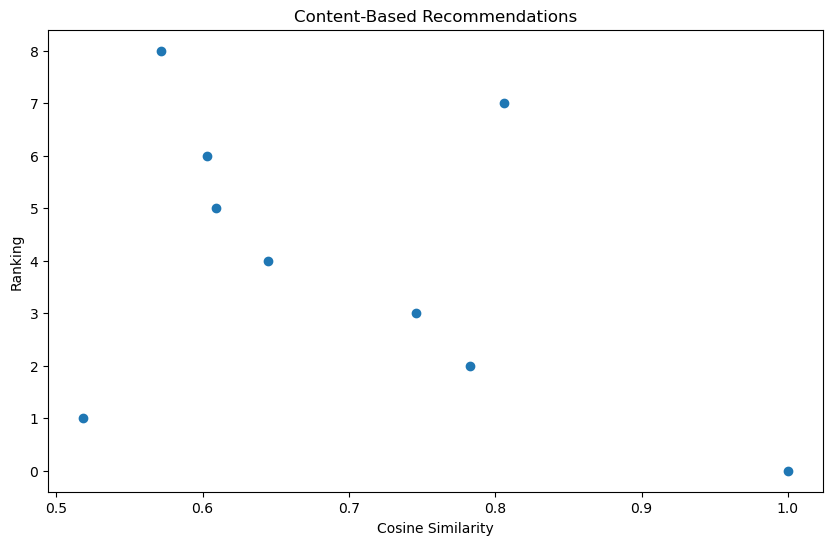

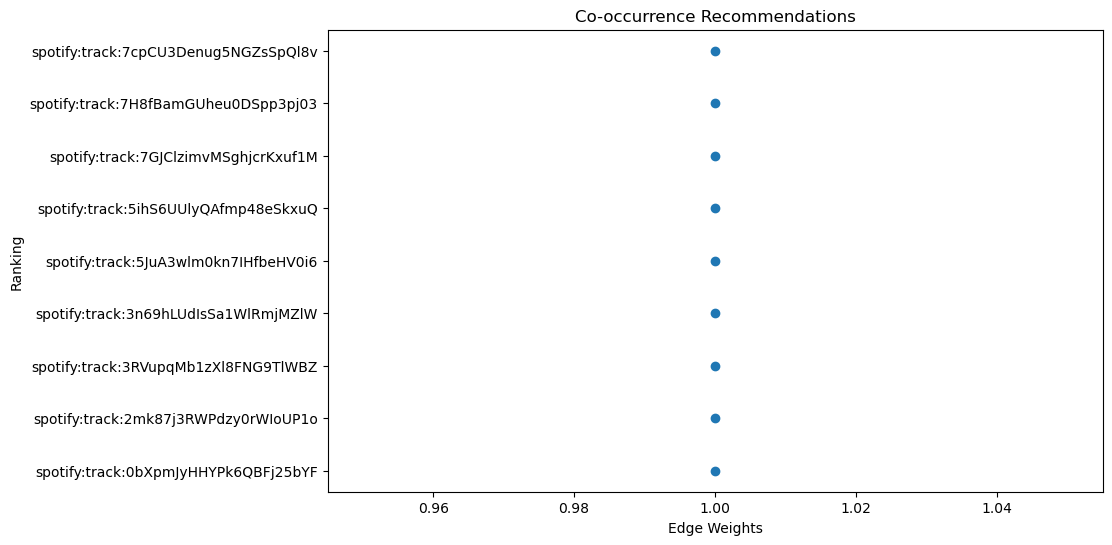

In [50]:
import matplotlib.pyplot as plt

# Plot for content-based recommendations
plt.figure(figsize=(10, 6))
plt.plot(cosine_similarities.flatten(), ranked_neighbors_cosine, 'o')

plt.xlabel('Cosine Similarity')
plt.ylabel('Ranking')
plt.title('Content-Based Recommendations')
plt.show()


# Plot for co-occurrence recommendations
plt.figure(figsize=(10, 6))
plt.plot(list(edge_weights.values()), ranked_neighbors_co_occurrence, 'o')
plt.xlabel('Edge Weights')
plt.ylabel('Ranking')
plt.title('Co-occurrence Recommendations')
plt.show()
